In [7]:
from pathlib import Path
import os

# ✅ Auto-detect repo root by walking up until we find "data" and "api"
HERE = Path.cwd().resolve()

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "data").exists() and (p / "api").exists():
            return p
    raise RuntimeError("Could not find repo root. Open notebook from inside the repo folder.")

REPO_ROOT = find_repo_root(HERE)
os.chdir(REPO_ROOT)

print("✅ REPO_ROOT:", REPO_ROOT)
print("✅ CWD:", Path.cwd())


✅ REPO_ROOT: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection
✅ CWD: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection


In [ ]:
from pathlib import Path

DATA_DIR = REPO_ROOT / "data" / "processed"
ART_DIR  = REPO_ROOT / "artifacts"
ART_DIR_MODEL  = REPO_ROOT / "artifacts"/ "models"

TRAIN_PATH = DATA_DIR / "train.csv"
VAL_PATH   = DATA_DIR / "val.csv"
TEST_PATH  = DATA_DIR / "test.csv"

MODEL_PATH   = ART_DIR_MODEL / "xgb_model.pkl"
METRICS_PATH = ART_DIR / "xgb_metrics.json"

FIG_DIR = REPO_ROOT / "docs" / "figures" / "models" / "04_xgboost"
FIG_DIR.mkdir(parents=True, exist_ok=True)

for p in [TRAIN_PATH, VAL_PATH, TEST_PATH, MODEL_PATH, METRICS_PATH]:
    print(p, "exists=", p.exists())


/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/data/processed/train.csv exists= True
/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/data/processed/val.csv exists= True
/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/data/processed/test.csv exists= True
/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/artifacts/xgb_model.pkl exists= False
/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/artifacts/xgb_metrics.json exists= False


In [9]:
import pandas as pd
import numpy as np

TARGET_COL = "Class"

def load_processed(path: Path, target_col: str = TARGET_COL):
    df = pd.read_csv(path)
    y = df[target_col].astype(int).values
    X = df.drop(columns=[target_col])
    return df, X, y

train_df, X_train_df, y_train = load_processed(TRAIN_PATH)
val_df, X_val_df, y_val = load_processed(VAL_PATH)
test_df, X_test_df, y_test = load_processed(TEST_PATH)

print("Train:", X_train_df.shape, "Fraud rate:", y_train.mean())
print("Val:  ", X_val_df.shape,   "Fraud rate:", y_val.mean())
print("Test: ", X_test_df.shape,  "Fraud rate:", y_test.mean())


Train: (397960, 102) Fraud rate: 0.5
Val:   (42721, 102) Fraud rate: 0.001310830738980829
Test:  (42722, 102) Fraud rate: 0.0012171714807359207


In [10]:
import json, joblib

xgb = joblib.load(MODEL_PATH)

with open(METRICS_PATH, "r") as f:
    metrics_json = json.load(f)

threshold = float(metrics_json.get("threshold", 0.5))
print("✅ Loaded model + threshold =", threshold)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/artifacts/xgb_model.pkl'

In [ ]:
val_probs = xgb.predict_proba(X_val_df)[:, 1]
test_probs = xgb.predict_proba(X_test_df)[:, 1]

print("val probs min/max/mean:", float(val_probs.min()), float(val_probs.max()), float(val_probs.mean()))
print("test probs min/max/mean:", float(test_probs.min()), float(test_probs.max()), float(test_probs.mean()))


val probs min/max/mean: 3.6376918615133036e-06 0.9999608993530273 0.0013851550174877048
test probs min/max/mean: 3.890143034368521e-06 0.9999697208404541 0.001320401905104518


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Predictions
val_pred = (val_probs >= threshold).astype(int)
test_pred = (test_probs >= threshold).astype(int)

# Confusion matrices
cm_val = confusion_matrix(y_val, val_pred)
cm_test = confusion_matrix(y_test, test_pred)

def plot_confusion_matrix(cm, title, save_path):
    # Normalize by true labels (row-wise)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 5))
    im = plt.imshow(cm_norm, cmap="Blues")

    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)

    # Annotate with absolute values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                f"{cm[i, j]}",
                ha="center",
                va="center",
                color="black",
                fontsize=12,
                fontweight="bold",
            )

    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

# Plot VAL confusion matrix
plot_confusion_matrix(
    cm_val,
    f"XGBoost Confusion Matrix (VAL) @ t={threshold:.4f}",
    FIG_DIR / "xgb_confusion_val.png",
)

# Plot TEST confusion matrix
plot_confusion_matrix(
    cm_test,
    f"XGBoost Confusion Matrix (TEST) @ t={threshold:.4f}",
    FIG_DIR / "xgb_confusion_test.png",
)

print("✅ Saved improved confusion matrices to:", FIG_DIR)


NameError: name 'val_probs' is not defined

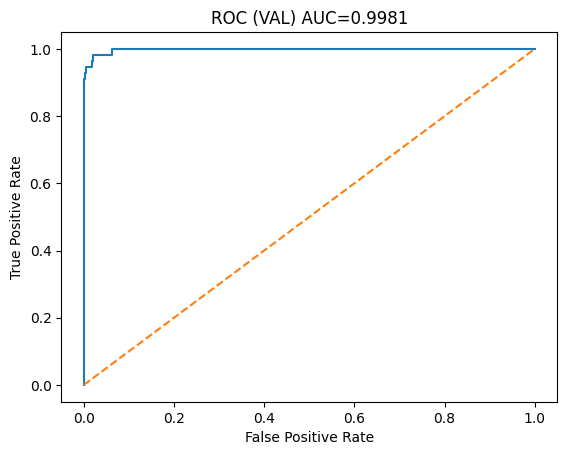

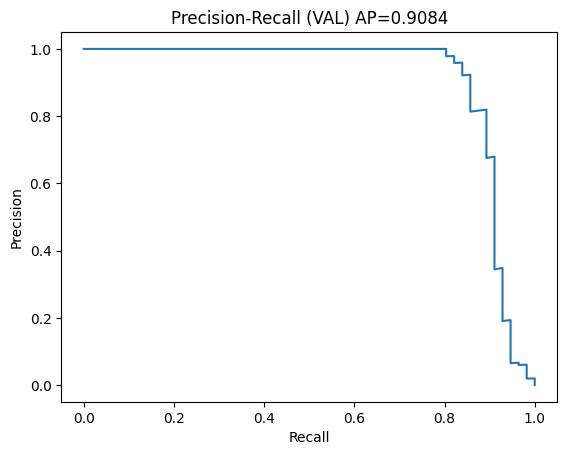

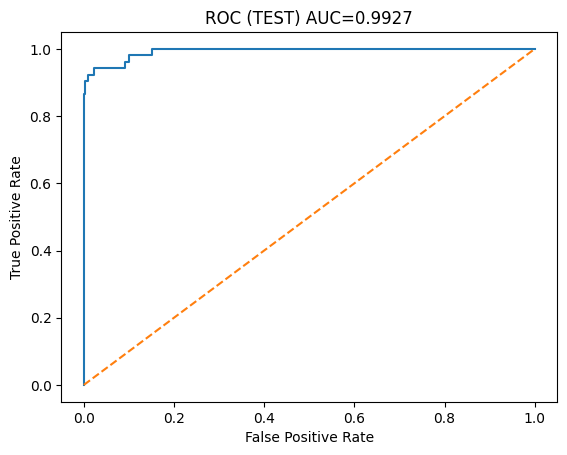

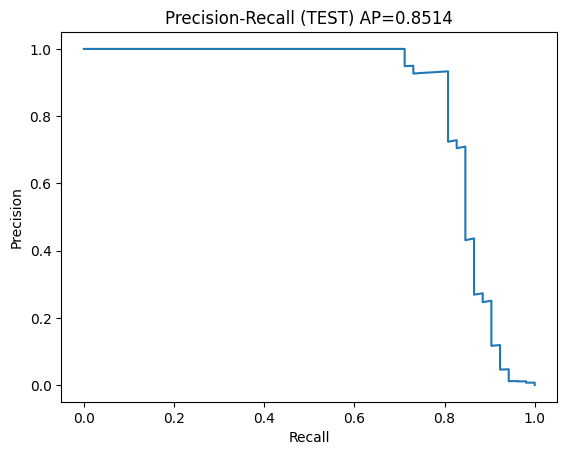

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ROC (VAL)
fpr, tpr, _ = roc_curve(y_val, val_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title(f"ROC (VAL) AUC={roc_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig(FIG_DIR / "xgb_roc_val.png", dpi=200, bbox_inches="tight")
plt.show()

# PR (VAL)
prec, rec, _ = precision_recall_curve(y_val, val_probs)
ap = average_precision_score(y_val, val_probs)
plt.plot(rec, prec)
plt.title(f"Precision-Recall (VAL) AP={ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig(FIG_DIR / "xgb_pr_val.png", dpi=200, bbox_inches="tight")
plt.show()

# ROC (TEST)
fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title(f"ROC (TEST) AUC={roc_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig(FIG_DIR / "xgb_roc_test.png", dpi=200, bbox_inches="tight")
plt.show()

# PR (TEST)
prec, rec, _ = precision_recall_curve(y_test, test_probs)
ap = average_precision_score(y_test, test_probs)
plt.plot(rec, prec)
plt.title(f"Precision-Recall (TEST) AP={ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig(FIG_DIR / "xgb_pr_test.png", dpi=200, bbox_inches="tight")
plt.show()


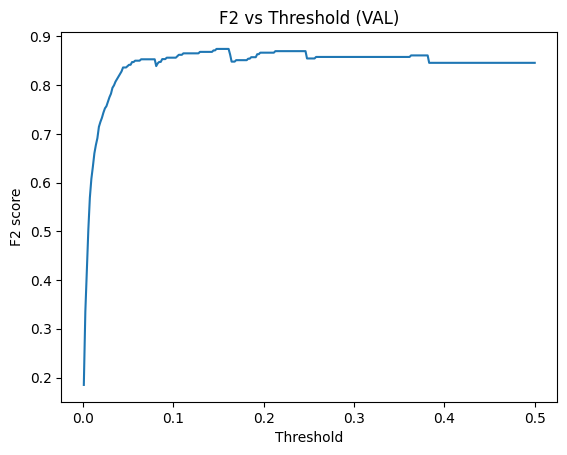

Best t (by F2 on VAL): 0.1478628762541806 F2: 0.8741258741258742
Current saved threshold: 0.162


In [ ]:
from sklearn.metrics import fbeta_score

ths = np.linspace(0.001, 0.5, 300)
f2s = []
for t in ths:
    f2s.append(fbeta_score(y_val, (val_probs >= t).astype(int), beta=2, zero_division=0))

plt.plot(ths, f2s)
plt.title("F2 vs Threshold (VAL)")
plt.xlabel("Threshold")
plt.ylabel("F2 score")
plt.savefig(FIG_DIR / "xgb_f2_vs_threshold_val.png", dpi=200, bbox_inches="tight")
plt.show()

best_idx = int(np.argmax(f2s))
print("Best t (by F2 on VAL):", float(ths[best_idx]), "F2:", float(f2s[best_idx]))
print("Current saved threshold:", threshold)
